# 🎯 DBSCAN Clustering Analysis

This notebook performs **DBSCAN clustering** on supplier performance data to identify distinct supplier groups.

## 🎯 What is DBSCAN?

- **Density-Based Algorithm**: Groups points based on density rather than distance
- **No predefined clusters**: Automatically determines number of clusters
- **Handles noise**: Identifies outliers as noise points
- **Best for**: Arbitrary-shaped clusters, noise detection

## 🎯 Key Parameters

- **eps**: Maximum distance between points in a neighborhood
- **min_samples**: Minimum points required to form a dense region
- **Core points**: Points with at least min_samples neighbors within eps
- **Border points**: Points within eps of core points but not core themselves
- **Noise points**: Points that are neither core nor border

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings
import os
from datetime import datetime

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
def load_cleaned_data(file_path='../data/processed/cleaned_data.csv'):
    """Load the cleaned supplier data for clustering"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Cleaned data file not found: {file_path}")
        
    print(f"Loading cleaned data from {file_path}")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df):,} rows with {len(df.columns)} columns")
    
    # Basic info
    print(f"\nDataset overview:")
    print(f"   • Unique suppliers: {df['supplier_id'].nunique()}")
    print(f"   • Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"   • Performance score range: {df['overall_score'].min():.1f} - {df['overall_score'].max():.1f}")
    
    return df

# Load the data
df = load_cleaned_data()

# Show sample data
print("\nSample data (first 3 rows):")
df.head(3)

Loading cleaned data from ../data/processed/cleaned_data.csv
Loaded 2,994 rows with 21 columns

Dataset overview:
   • Unique suppliers: 25
   • Date range: 2015-01-01 to 2024-12-01
   • Performance score range: 39.8 - 87.0

Sample data (first 3 rows):


,date,year,month,quarter,supplier_id,company_name,company_size,industry,location,delivery_reliability,...,defect_rate,quality_score,on_time_delivery_rate,order_volume,response_time_hours,customer_satisfaction,overall_score,performance_category,defect_cost_impact,efficiency_ratio
0,2015-01-01,2015,1,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,78.844749,...,1.362205,86.623620,75.458909,316.0,21.961844,7.926791,79.83,Good,21522.84,1.306
1,2015-02-01,2015,2,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,75.012850,...,1.026724,84.857776,75.355035,352.0,22.700895,7.965200,79.27,Good,18070.35,1.267
2,2015-03-01,2015,3,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,71.885296,...,0.325915,83.383238,74.145862,273.0,22.536271,7.667606,79.22,Good,4448.74,1.245


In [6]:
def prepare_clustering_features(df):
    """Prepare and select features for DBSCAN clustering"""    
    # Select key performance features for clustering
    # These represent the core supplier performance dimensions
    clustering_features = [
        'delivery_reliability',     # How reliable are deliveries?
        'cost_efficiency',          # How cost-effective?
        'defect_rate',              # Quality indicator (lower is better)
        'quality_score',            # Overall quality rating
        'on_time_delivery_rate',    # Punctuality
        'response_time_hours',      # Customer service speed (lower is better)
        'customer_satisfaction'     # Customer happiness
    ]
    
    print(f"Selected {len(clustering_features)} features for clustering:")
    for i, feature in enumerate(clustering_features, 1):
        print(f"   {i}. {feature}")
    
    # Extract feature matrix
    X = df[clustering_features].values
    print(f"\nOriginal feature matrix shape: {X.shape}")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Features standardized (mean=0, std=1)")
    print(f"Scaled feature matrix shape: {X_scaled.shape}")
    
    # Show feature statistics after scaling
    print("\nFeature statistics after scaling:")
    scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)
    stats = scaled_df.describe().round(3)
    print(stats)
    
    # Check for any remaining issues
    if np.isnan(X_scaled).any():
        print("Warning: NaN values found after scaling")
    else:
        print("No NaN values in scaled data")
    
    return X_scaled, scaler, clustering_features, df

# Prepare features
X_scaled, scaler, clustering_features, df_original = prepare_clustering_features(df)

Selected 7 features for clustering:
   1. delivery_reliability
   2. cost_efficiency
   3. defect_rate
   4. quality_score
   5. on_time_delivery_rate
   6. response_time_hours
   7. customer_satisfaction

Original feature matrix shape: (2994, 7)
Features standardized (mean=0, std=1)
Scaled feature matrix shape: (2994, 7)

Feature statistics after scaling:
       delivery_reliability  cost_efficiency  defect_rate  quality_score  \
count              2994.000         2994.000     2994.000       2994.000   
mean                 -0.000            0.000       -0.000         -0.000   
std                   1.000            1.000        1.000          1.000   
min                  -2.959           -2.075       -1.486         -1.447   
25%                  -0.535           -0.731       -0.686         -0.942   
50%                  -0.077            0.114       -0.160         -0.125   
75%                   0.658            0.852        0.442          0.885   
max                   2.541      

Determining optimal eps range using k-distance analysis...


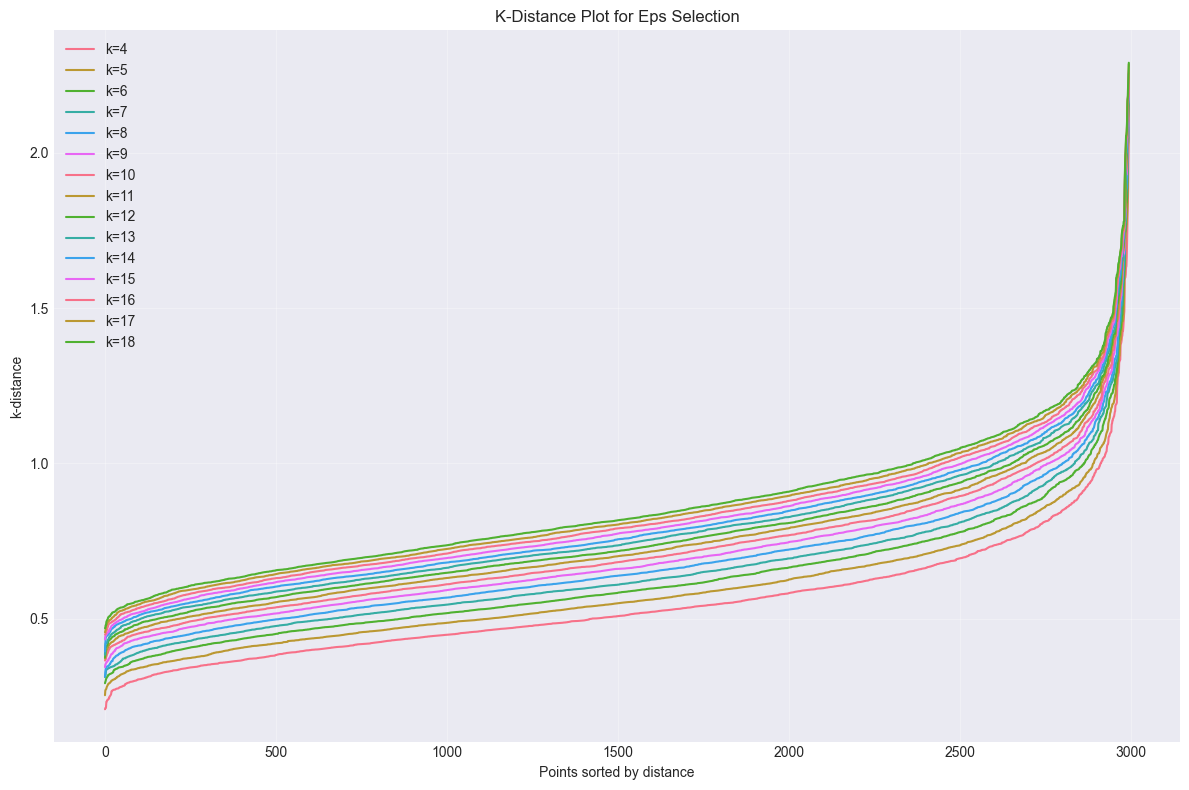


Grid search: 12 eps values × 8 min_samples values
Testing parameter combinations...
   eps=0.5, min_samples=5: 47 clusters, 1298 noise (43.4%), sil=0.275
   eps=0.5, min_samples=5: 47 clusters, 1298 noise (43.4%), sil=0.275
   eps=0.7, min_samples=5: 16 clusters, 266 noise (8.9%), sil=0.142
   eps=0.7, min_samples=7: 18 clusters, 351 noise (11.7%), sil=0.203
   eps=0.7, min_samples=5: 16 clusters, 266 noise (8.9%), sil=0.142
   eps=0.7, min_samples=7: 18 clusters, 351 noise (11.7%), sil=0.203
   eps=0.7, min_samples=9: 18 clusters, 472 noise (15.8%), sil=0.255
   eps=0.7, min_samples=11: 19 clusters, 603 noise (20.1%), sil=0.257
   eps=0.7, min_samples=9: 18 clusters, 472 noise (15.8%), sil=0.255
   eps=0.7, min_samples=11: 19 clusters, 603 noise (20.1%), sil=0.257
   eps=0.7, min_samples=13: 18 clusters, 763 noise (25.5%), sil=0.323
   eps=0.7, min_samples=15: 18 clusters, 915 noise (30.6%), sil=0.339
   eps=0.7, min_samples=17: 19 clusters, 1037 noise (34.6%), sil=0.328
   eps=0.7, 

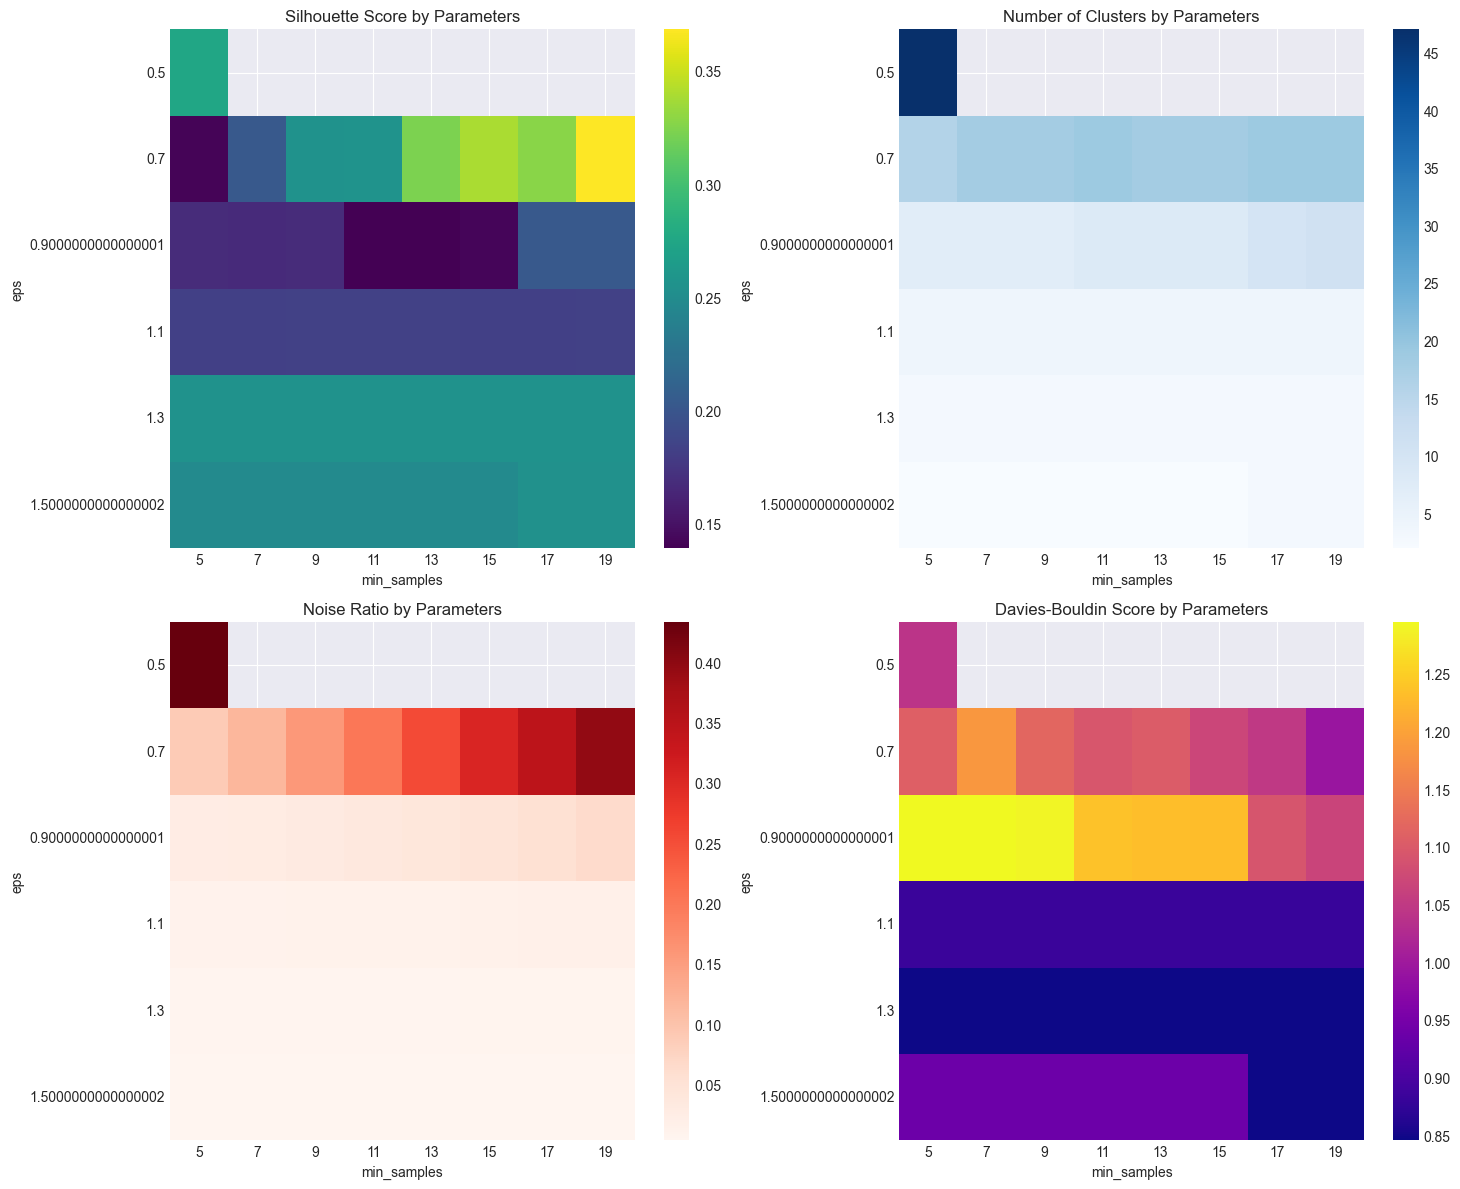

In [10]:
def find_optimal_dbscan_params(X_scaled):
    """Find optimal DBSCAN parameters using grid search and evaluation metrics"""
    
    # First, determine reasonable eps range using k-distance plot
    print("Determining optimal eps range using k-distance analysis...")
    
    # Use min_samples = 2 * n_features as a starting point
    min_samples_base = 2 * X_scaled.shape[1]  # 14 for our 7 features
    
    # Calculate k-distance for different k
    k_distances = []
    k_range = range(4, min_samples_base + 5)  # Around the min_samples
    
    for k in k_range:
        neigh = NearestNeighbors(n_neighbors=k)
        neigh.fit(X_scaled)
        distances, _ = neigh.kneighbors(X_scaled)
        k_distances.append(np.sort(distances[:, -1]))
    
    # Plot k-distance curves
    plt.figure(figsize=(12, 8))
    
    for i, k in enumerate(k_range):
        plt.plot(np.sort(k_distances[i]), label=f'k={k}')
    
    plt.xlabel('Points sorted by distance')
    plt.ylabel('k-distance')
    plt.title('K-Distance Plot for Eps Selection')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../data/results/dbscan_kdistance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Suggest eps range based on the elbow in k-distance
    # Typically, eps is chosen at the "knee" of the curve
    suggested_eps_range = np.linspace(0.5, 2.0, 10)  # Conservative range
    
    # Grid search for optimal parameters
    eps_range = np.linspace(0.3, 2.5, 12)
    min_samples_range = range(5, 21, 2)  # 5, 7, 9, ..., 19
    
    print(f"\nGrid search: {len(eps_range)} eps values × {len(min_samples_range)} min_samples values")
    print("Testing parameter combinations...")
    
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            # Apply DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_scaled)
            
            # Count clusters and noise
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Only evaluate if we have clusters and not too much noise
            if n_clusters >= 2 and n_noise < len(X_scaled) * 0.5:  # At least 2 clusters, less than 50% noise
                # Calculate metrics on non-noise points
                mask = labels != -1
                if np.sum(mask) >= 2:  # Need at least 2 points for metrics
                    try:
                        silhouette = silhouette_score(X_scaled[mask], labels[mask])
                        davies_bouldin = davies_bouldin_score(X_scaled[mask], labels[mask])
                        calinski_harabasz = calinski_harabasz_score(X_scaled[mask], labels[mask])
                        
                        results.append({
                            'eps': eps,
                            'min_samples': min_samples,
                            'n_clusters': n_clusters,
                            'n_noise': n_noise,
                            'noise_ratio': n_noise / len(X_scaled),
                            'silhouette': silhouette,
                            'davies_bouldin': davies_bouldin,
                            'calinski_harabasz': calinski_harabasz
                        })
                        
                        print(f"   eps={eps:.1f}, min_samples={min_samples}: {n_clusters} clusters, "
                              f"{n_noise} noise ({n_noise/len(X_scaled):.1%}), sil={silhouette:.3f}")
                    except:
                        continue
    
    if not results:
        print("No valid parameter combinations found. Using default values.")
        return 0.8, 10  # Default values
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Find best parameters based on silhouette score
    best_idx = results_df['silhouette'].idxmax()
    best_params = results_df.loc[best_idx]
    
    print(f"\nBest parameters found:")
    print(f"   eps: {best_params['eps']:.3f}")
    print(f"   min_samples: {int(best_params['min_samples'])}")
    print(f"   Clusters: {int(best_params['n_clusters'])}")
    print(f"   Noise points: {int(best_params['n_noise'])} ({best_params['noise_ratio']:.1%})")
    print(f"   Silhouette score: {best_params['silhouette']:.3f}")
    print(f"   Davies-Bouldin score: {best_params['davies_bouldin']:.3f}")
    print(f"   Calinski-Harabasz score: {best_params['calinski_harabasz']:.3f}")
    
    # Visualize parameter search results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Silhouette score heatmap
    pivot_sil = results_df.pivot(index='eps', columns='min_samples', values='silhouette')
    sns.heatmap(pivot_sil, ax=ax1, cmap='viridis', annot=False, cbar=True)
    ax1.set_title('Silhouette Score by Parameters')
    
    # Number of clusters heatmap
    pivot_clusters = results_df.pivot(index='eps', columns='min_samples', values='n_clusters')
    sns.heatmap(pivot_clusters, ax=ax2, cmap='Blues', annot=False, cbar=True)
    ax2.set_title('Number of Clusters by Parameters')
    
    # Noise ratio heatmap
    pivot_noise = results_df.pivot(index='eps', columns='min_samples', values='noise_ratio')
    sns.heatmap(pivot_noise, ax=ax3, cmap='Reds', annot=False, cbar=True)
    ax3.set_title('Noise Ratio by Parameters')
    
    # Davies-Bouldin score heatmap
    pivot_db = results_df.pivot(index='eps', columns='min_samples', values='davies_bouldin')
    sns.heatmap(pivot_db, ax=ax4, cmap='plasma', annot=False, cbar=True)
    ax4.set_title('Davies-Bouldin Score by Parameters')
    
    plt.tight_layout()
    plt.savefig('../data/results/dbscan_parameter_search.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_params['eps'], int(best_params['min_samples'])

# Find optimal DBSCAN parameters
optimal_eps, optimal_min_samples = find_optimal_dbscan_params(X_scaled)

In [11]:
def apply_dbscan_clustering(X_scaled, eps, min_samples, df_original):
    """Apply DBSCAN clustering with optimal parameters"""
    print(f"Clustering {len(X_scaled):,} data points with DBSCAN")
    print(f"Parameters: eps={eps:.3f}, min_samples={min_samples}")
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X_scaled)
    
    print("DBSCAN clustering completed!")
    
    # Analyze results
    unique_labels = set(cluster_labels)
    n_clusters = len(unique_labels) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    print(f"Number of clusters found: {n_clusters}")
    print(f"Number of noise points: {n_noise} ({n_noise/len(X_scaled):.1%})")
    
    # Add cluster labels to original data
    df_clustered = df_original.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Add descriptive cluster names (for clustered points)
    cluster_names = {}
    for i in range(n_clusters):
        cluster_names[i] = f'Cluster_{i+1}'
    cluster_names[-1] = 'Noise'
    
    df_clustered['cluster_name'] = df_clustered['cluster'].map(cluster_names)
    
    # Show cluster distribution
    print("\nCluster Distribution:")
    cluster_counts = df_clustered['cluster_name'].value_counts().sort_index(key=lambda x: [int(c.split('_')[1]) if '_' in c else 999 for c in x])
    for cluster_name, count in cluster_counts.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"   • {cluster_name}: {count:,} suppliers ({percentage:.1f}%)")
    
    # Calculate core sample indices
    core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    
    print(f"\nCore samples: {np.sum(core_samples_mask)} out of {len(X_scaled)} points")
    
    return df_clustered, dbscan, core_samples_mask

# Apply DBSCAN clustering
df_clustered, dbscan_model, core_samples_mask = apply_dbscan_clustering(X_scaled, optimal_eps, optimal_min_samples, df_original)

Clustering 2,994 data points with DBSCAN
Parameters: eps=0.700, min_samples=19
DBSCAN clustering completed!
Number of clusters found: 19
Number of noise points: 1184 (39.5%)

Cluster Distribution:
   • Cluster_1: 111 suppliers (3.7%)
   • Cluster_2: 64 suppliers (2.1%)
   • Cluster_3: 20 suppliers (0.7%)
   • Cluster_4: 87 suppliers (2.9%)
   • Cluster_5: 213 suppliers (7.1%)
   • Cluster_6: 84 suppliers (2.8%)
   • Cluster_7: 86 suppliers (2.9%)
   • Cluster_8: 19 suppliers (0.6%)
   • Cluster_9: 112 suppliers (3.7%)
   • Cluster_10: 19 suppliers (0.6%)
   • Cluster_11: 109 suppliers (3.6%)
   • Cluster_12: 96 suppliers (3.2%)
   • Cluster_13: 106 suppliers (3.5%)
   • Cluster_14: 102 suppliers (3.4%)
   • Cluster_15: 134 suppliers (4.5%)
   • Cluster_16: 160 suppliers (5.3%)
   • Cluster_17: 196 suppliers (6.5%)
   • Cluster_18: 72 suppliers (2.4%)
   • Cluster_19: 20 suppliers (0.7%)
   • Noise: 1,184 suppliers (39.5%)

Core samples: 699 out of 2994 points


In [14]:
def analyze_cluster_characteristics(df_clustered, core_samples_mask):
    """Analyze the characteristics of each cluster"""   
    # Separate clustered and noise data
    df_clustered_only = df_clustered[df_clustered['cluster'] != -1].copy()
    
    if len(df_clustered_only) == 0:
        print("No clusters found! All points are noise.")
        return None, None
    
    # Group by cluster and calculate mean performance metrics (only for clustered points)
    cluster_summary = df_clustered_only.groupby('cluster_name').agg({
        'delivery_reliability': 'mean',
        'cost_efficiency': 'mean',
        'defect_rate': 'mean',
        'quality_score': 'mean',
        'on_time_delivery_rate': 'mean',
        'response_time_hours': 'mean',
        'customer_satisfaction': 'mean',
        'overall_score': 'mean',
        'supplier_id': 'count'
    }).round(2)
    
    # Rename count column
    cluster_summary = cluster_summary.rename(columns={'supplier_id': 'supplier_count'})
    
    # Add noise summary
    noise_df = df_clustered[df_clustered['cluster'] == -1]
    noise_count = len(noise_df)
    if noise_count > 0:
        noise_summary = pd.DataFrame({
            'supplier_count': [noise_count],
            'delivery_reliability': [noise_df['delivery_reliability'].mean()],
            'cost_efficiency': [noise_df['cost_efficiency'].mean()],
            'defect_rate': [noise_df['defect_rate'].mean()],
            'quality_score': [noise_df['quality_score'].mean()],
            'on_time_delivery_rate': [noise_df['on_time_delivery_rate'].mean()],
            'response_time_hours': [noise_df['response_time_hours'].mean()],
            'customer_satisfaction': [noise_df['customer_satisfaction'].mean()],
            'overall_score': [noise_df['overall_score'].mean()]
        }, index=['Noise']).round(2)
    else:
        noise_summary = pd.DataFrame({
            'supplier_count': [0],
            'delivery_reliability': [0.0],
            'cost_efficiency': [0.0],
            'defect_rate': [0.0],
            'quality_score': [0.0],
            'on_time_delivery_rate': [0.0],
            'response_time_hours': [0.0],
            'customer_satisfaction': [0.0],
            'overall_score': [0.0]
        }, index=['Noise'])
    
    # Combine summaries
    full_summary = pd.concat([cluster_summary, noise_summary])
    
    print("Cluster Performance Summary (including noise):")
    print(full_summary)
    
    # Create detailed cluster profiles
    print("\nDetailed Cluster Profiles:")
    print("="*60)
    
    for cluster_name in full_summary.index:
        if cluster_name != 'Noise':
            stats = full_summary.loc[cluster_name]
            print(f"\n{cluster_name} ({stats['supplier_count']} suppliers)")
            print(f"   Overall Score: {stats['overall_score']:.1f}/100")
            print(f"   Delivery Reliability: {stats['delivery_reliability']:.1f}%")
            print(f"   Cost Efficiency: {stats['cost_efficiency']:.1f}%")
            print(f"   Defect Rate: {stats['defect_rate']:.2f}%")
            print(f"   Quality Score: {stats['quality_score']:.1f}%")
            print(f"   Customer Satisfaction: {stats['customer_satisfaction']:.1f}/10")
        else:
            stats = full_summary.loc[cluster_name]
            print(f"\n{cluster_name} ({stats['supplier_count']} suppliers)")
            print("   Outlier suppliers that don't belong to any cluster")
            print(f"   Average Overall Score: {stats['overall_score']:.1f}/100")
    
    # Calculate evaluation metrics for clustered points only
    if len(df_clustered_only) > 1:
        clustered_labels = df_clustered_only['cluster'].values
        if len(set(clustered_labels)) > 1:
            silhouette = silhouette_score(X_scaled[df_clustered['cluster'] != -1], clustered_labels)
            davies_bouldin = davies_bouldin_score(X_scaled[df_clustered['cluster'] != -1], clustered_labels)
            calinski_harabasz = calinski_harabasz_score(X_scaled[df_clustered['cluster'] != -1], clustered_labels)
            
            print("Clustering Quality Metrics (on clustered points only):")
            print(f"   Silhouette Score: {silhouette:.3f}")
            print(f"   Davies-Bouldin Score: {davies_bouldin:.3f}")
            print(f"   Calinski-Harabasz Score: {calinski_harabasz:.3f}")
    
    return full_summary, core_samples_mask

# Analyze cluster characteristics
cluster_summary, core_samples_mask = analyze_cluster_characteristics(df_clustered, core_samples_mask)

Cluster Performance Summary (including noise):
            delivery_reliability  cost_efficiency  defect_rate  quality_score  \
Cluster_1                  66.75            65.15         1.73          73.72   
Cluster_10                 74.51            71.20         1.78          40.00   
Cluster_11                 44.30            83.68         1.72          49.45   
Cluster_12                 48.53            60.73         1.81          89.62   
Cluster_13                 60.51            70.83         1.83          81.68   
Cluster_14                 56.30            83.36         1.74          61.25   
Cluster_15                 72.43            76.25         1.80          84.78   
Cluster_16                 62.81            80.44         1.74          45.86   
Cluster_17                 62.27            39.56         1.73          92.54   
Cluster_18                 74.85            58.79         1.67          40.57   
Cluster_19                 91.29            59.95         4.65

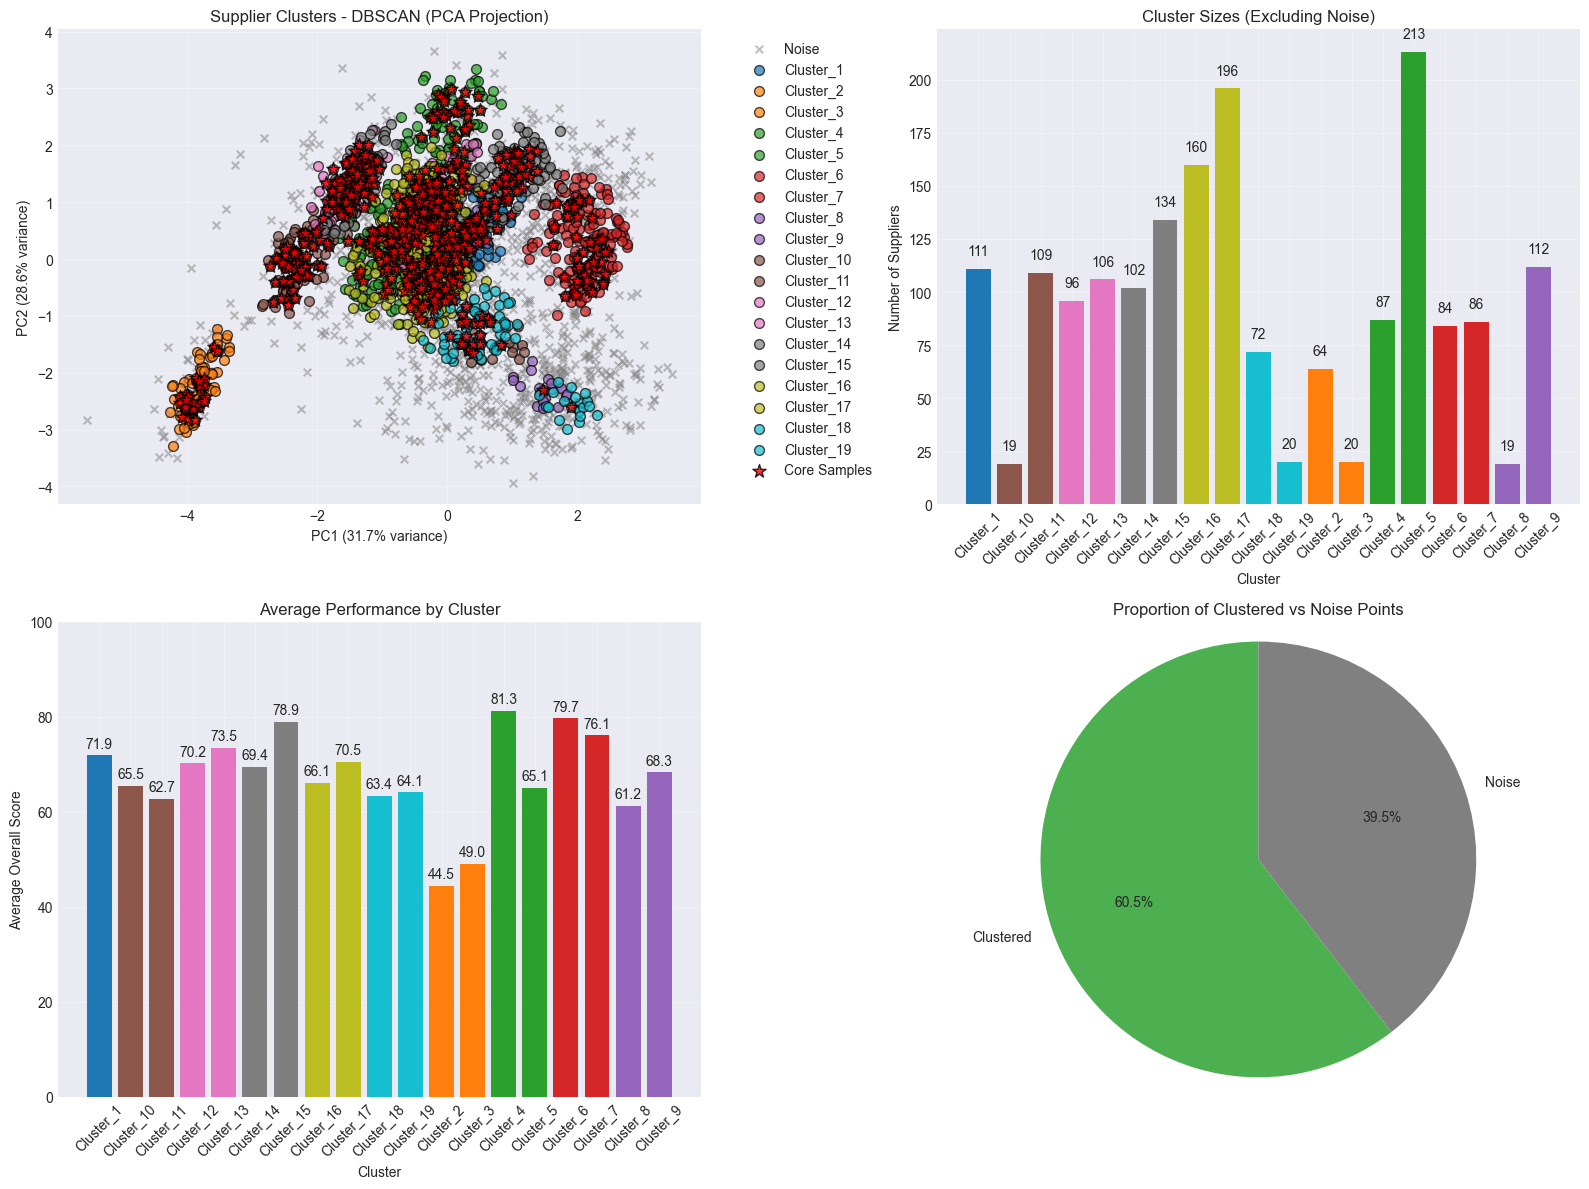

Clustering visualizations saved!


In [15]:
def visualize_clustering_results(df_clustered, X_scaled, core_samples_mask):
    """Create visualizations for the clustering results"""
    # Set up color scheme for clusters
    unique_labels = set(df_clustered['cluster'])
    n_clusters = len(unique_labels) - (1 if -1 in df_clustered['cluster'] else 0)
    
    # Generate colors
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters + 1))  # +1 for noise
    cluster_colors = {}
    for i, label in enumerate(sorted(unique_labels)):
        if label == -1:
            cluster_colors['Noise'] = '#808080'  # Gray for noise
        else:
            cluster_colors[f'Cluster_{label+1}'] = colors[i]
    
    # 2D PCA visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(16, 12))
    
    # Plot 1: PCA scatter plot
    plt.subplot(2, 2, 1)
    for cluster_name, color in cluster_colors.items():
        mask = df_clustered['cluster_name'] == cluster_name
        marker = 'x' if cluster_name == 'Noise' else 'o'
        alpha = 0.5 if cluster_name == 'Noise' else 0.7
        size = 30 if cluster_name == 'Noise' else 50
        
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=color, label=cluster_name, alpha=alpha, s=size, marker=marker, edgecolors='black')
    
    # Highlight core samples
    core_mask = core_samples_mask
    plt.scatter(X_pca[core_mask, 0], X_pca[core_mask, 1], 
               c='red', marker='*', s=100, edgecolors='black', linewidth=1,
               label='Core Samples', alpha=0.8)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('Supplier Clusters - DBSCAN (PCA Projection)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Cluster size comparison (excluding noise for bar chart)
    plt.subplot(2, 2, 2)
    cluster_sizes = df_clustered[df_clustered['cluster'] != -1]['cluster_name'].value_counts().sort_index()
    if len(cluster_sizes) > 0:
        bars = plt.bar(range(len(cluster_sizes)), cluster_sizes.values, 
                       color=[cluster_colors[name] for name in cluster_sizes.index])
        plt.xlabel('Cluster')
        plt.ylabel('Number of Suppliers')
        plt.title('Cluster Sizes (Excluding Noise)')
        plt.xticks(range(len(cluster_sizes)), cluster_sizes.index, rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, cluster_sizes.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{value}', ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, 'No clusters found', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('No Clusters Found')
    
    # Plot 3: Performance comparison by cluster
    plt.subplot(2, 2, 3)
    if len(cluster_sizes) > 0:
        overall_scores = df_clustered[df_clustered['cluster'] != -1].groupby('cluster_name')['overall_score'].mean()
        bars = plt.bar(range(len(overall_scores)), overall_scores.values,
                       color=[cluster_colors[name] for name in overall_scores.index])
        plt.xlabel('Cluster')
        plt.ylabel('Average Overall Score')
        plt.title('Average Performance by Cluster')
        plt.xticks(range(len(overall_scores)), overall_scores.index, rotation=45)
        plt.ylim(0, 100)
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, overall_scores.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{value:.1f}', ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, 'No clusters to compare', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('No Clusters to Compare')
    
    # Plot 4: Noise analysis
    plt.subplot(2, 2, 4)
    noise_ratio = (df_clustered['cluster'] == -1).mean()
    labels = ['Clustered', 'Noise']
    sizes = [1 - noise_ratio, noise_ratio]
    colors_pie = ['#4CAF50', '#808080']
    
    plt.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
    plt.title('Proportion of Clustered vs Noise Points')
    plt.axis('equal')
    
    plt.tight_layout()
    plt.savefig('../data/results/dbscan_clustering_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Clustering visualizations saved!")
    
    return X_pca

# Visualize clustering results
X_pca = visualize_clustering_results(df_clustered, X_scaled, core_samples_mask)

In [16]:
def generate_cluster_recommendations(cluster_summary):
    """Generate improvement recommendations for each cluster"""
    
    recommendations = {}
    
    # Generate recommendations for each cluster
    for cluster_name in cluster_summary.index:
        if cluster_name != 'Noise':
            stats = cluster_summary.loc[cluster_name]
            
            # Determine priority based on performance
            if stats['overall_score'] >= 80:
                priority = 'Maintain Excellence'
                recs = [
                    'Continue current high-performance practices',
                    'Share best practices with other suppliers',
                    'Consider premium partnerships or incentives',
                    'Monitor for any performance degradation'
                ]
            elif stats['overall_score'] >= 60:
                priority = 'Monitor & Improve'
                recs = [
                    'Focus on key weakness areas for improvement',
                    'Implement targeted quality control measures',
                    'Regular performance reviews and feedback',
                    'Consider additional training or support'
                ]
            else:
                priority = 'Critical Improvement Needed'
                recs = [
                    'Comprehensive quality management system implementation',
                    'Supplier development program enrollment',
                    'Process capability studies and improvements',
                    'Close monitoring and regular audits',
                    'Consider supplier replacement if no improvement'
                ]
            
            recommendations[cluster_name] = {
                'priority': priority,
                'recommendations': recs
            }
        else:
            # Recommendations for noise/outliers
            recommendations[cluster_name] = {
                'priority': 'Investigate Outliers',
                'recommendations': [
                    'Analyze why these suppliers don\'t fit typical patterns',
                    'Review data quality for outlier suppliers',
                    'Consider individual assessment and improvement plans',
                    'Monitor closely as they may represent unique cases',
                    'Evaluate if they should be excluded or given special attention'
                ]
            }
    
    print("Cluster Improvement Recommendations:")
    print("="*60)
    
    for cluster_name, data in recommendations.items():
        supplier_count = cluster_summary.loc[cluster_name, 'supplier_count']
        print(f"\n{cluster_name} ({supplier_count} suppliers) - {data['priority']}")
        
        for i, rec in enumerate(data['recommendations'], 1):
            print(f"   {i}. {rec}")
    
    # Create recommendations DataFrame
    rec_list = []
    for cluster_name, data in recommendations.items():
        for rec in data['recommendations']:
            rec_list.append({
                'cluster_name': cluster_name,
                'priority': data['priority'],
                'recommendation': rec
            })
    
    recommendations_df = pd.DataFrame(rec_list)
    
    print("\nRecommendations generated for all clusters!")
    
    return recommendations_df

# Generate recommendations
if cluster_summary is not None:
    recommendations_df = generate_cluster_recommendations(cluster_summary)
else:
    recommendations_df = pd.DataFrame()  # Empty if no clusters

Cluster Improvement Recommendations:

Cluster_1 (111 suppliers) - Monitor & Improve
   1. Focus on key weakness areas for improvement
   2. Implement targeted quality control measures
   3. Regular performance reviews and feedback
   4. Consider additional training or support

Cluster_10 (19 suppliers) - Monitor & Improve
   1. Focus on key weakness areas for improvement
   2. Implement targeted quality control measures
   3. Regular performance reviews and feedback
   4. Consider additional training or support

Cluster_11 (109 suppliers) - Monitor & Improve
   1. Focus on key weakness areas for improvement
   2. Implement targeted quality control measures
   3. Regular performance reviews and feedback
   4. Consider additional training or support

Cluster_12 (96 suppliers) - Monitor & Improve
   1. Focus on key weakness areas for improvement
   2. Implement targeted quality control measures
   3. Regular performance reviews and feedback
   4. Consider additional training or support

C

In [17]:
def save_clustering_results(df_clustered, cluster_summary, recommendations_df):
    """Save all clustering results to files"""
    # Create results directory
    os.makedirs('../data/results', exist_ok=True)
    
    # Save clustered data
    df_clustered.to_csv('../data/processed/dbscan_clustered_suppliers.csv', index=False)
    df_clustered.to_json('../data/processed/dbscan_clustered_suppliers.json', orient='records', indent=2, date_format='iso')
    print("Saved DBSCAN clustered supplier data")
    
    if cluster_summary is not None:
        # Save cluster summary
        cluster_summary.to_csv('../data/results/dbscan_cluster_summary.csv')
        print("Saved DBSCAN cluster performance summary")
    
    # Save recommendations
    if not recommendations_df.empty:
        recommendations_df.to_csv('../data/results/dbscan_cluster_recommendations.csv', index=False)
        print("Saved DBSCAN improvement recommendations")
    
    # Create final summary report
    n_clusters = len(df_clustered['cluster'].unique()) - (1 if -1 in df_clustered['cluster'].values else 0)
    n_noise = (df_clustered['cluster'] == -1).sum()
    
    summary_report = f"""
DBSCAN SUPPLIER CLUSTERING ANALYSIS REPORT

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}


DATASET OVERVIEW:

- Total Suppliers: {len(df_clustered)}
- Unique Suppliers: {df_clustered['supplier_id'].nunique()}
- Date Range: {df_clustered['date'].min()} to {df_clustered['date'].max()}
- Number of Clusters Found: {n_clusters}
- Number of Noise Points: {n_noise} ({n_noise/len(df_clustered):.1%})


CLUSTER DISTRIBUTION:

{df_clustered['cluster_name'].value_counts().to_string()}


CLUSTER PERFORMANCE SUMMARY:

{cluster_summary.to_string() if cluster_summary is not None else 'No clusters found - all points are noise'}


KEY FINDINGS:

1. Clustering Method: DBSCAN (Density-Based)
2. Parameters Used: eps={optimal_eps:.3f}, min_samples={optimal_min_samples}
3. {'Clusters identified with outliers detected' if n_clusters > 0 else 'No significant clusters found - data may be uniformly distributed'}
4. {'Noise points represent potential outliers requiring individual attention' if n_noise > 0 else 'No outliers detected in the dataset'}


RECOMMENDATIONS:

- {'Focus improvement efforts on clustered suppliers' if n_clusters > 0 else 'Consider alternative clustering approaches'}
- {'Investigate noise points individually' if n_noise > 0 else 'Data appears well-clustered'}
- {'Monitor cluster boundaries for supplier transitions' if n_clusters > 1 else 'Single cluster suggests uniform supplier performance'}
"""
    
    with open('../data/results/dbscan_clustering_summary_report.txt', 'w') as f:
        f.write(summary_report)
    
    print("Saved comprehensive DBSCAN summary report")
    
# Save all results
save_clustering_results(df_clustered, cluster_summary, recommendations_df)

Saved DBSCAN clustered supplier data
Saved DBSCAN cluster performance summary
Saved DBSCAN improvement recommendations
Saved comprehensive DBSCAN summary report
